## Generate the mesh

In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [2]:
from convert_mesh import convert_mesh

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)
nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)


meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
def run(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2
    import time

    start = time.perf_counter()
    run_festim_2(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


In [4]:
import ipyparallel as ipp
import numpy as np

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.72s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 86132, 'identifier': 'ipcontroller-1730160526-7y0g-86083'}
Stopping engine(s): 1730160527
Output for ipengine-1730160526-7y0g-1730160527-86083:
2024-10-28 20:08:48.309 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:08:48.309 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:08:48.432 [IPEngine] Registering with controller at tcp://127.0.0.1:57001
2024-10-28 20:08:48.437 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:56209', 'tcp://127.0.0.1:45211', 'tcp://127.0.0.1:39513']
2024-10-28 20:08:48.437 [IPEngine] Connecting shell to tcp://127.0.0.1:56209
2024-10-28 20:08:48.437 [IPEngine] Connecting shell to tcp://127.0.0.1:45211
2024-10-28 20:08:48.437 [IPEngine] Connecting shell to tcp://127.0.0.1:39513
2024-10-28 20:08:48.437 [IPEngin

/tmp/ipykernel_86083/3735946821.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_86083/3735946821.py:32: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.89s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 86517, 'identifier': 'ipcontroller-1730160573-55e8-86083'}
Stopping engine(s): 1730160574
Output for ipengine-1730160573-55e8-1730160574-86083:
2024-10-28 20:09:35.199 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:09:35.199 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:09:35.200 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:09:35.200 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:09:35.297 [IPEngine.0] Registering with controller at tcp://127.0.0.1:34223
2024-10-28 20:09:35.298 [IPEngine.1] Registering with controller at tcp://127.0.0.1:34223
2024-10-28 20:09:35.298 [IPEngine.0] Requesting id: 0
2024-10-28 20:09:35.298 [IPEngine.1] Requesting id: 1
2024-10-28 20:09:35.302 [IPEngine.0] Shell_addrs: ['tc

/tmp/ipykernel_86083/3735946821.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_86083/3735946821.py:32: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.44s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 86808, 'identifier': 'ipcontroller-1730160606-i8bu-86083'}
Stopping engine(s): 1730160608
Output for ipengine-1730160606-i8bu-1730160608-86083:
2024-10-28 20:10:08.472 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:10:08.472 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:10:08.473 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:10:08.473 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:10:08.476 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:10:08.477 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:10:08.478 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 20:10:08.479 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 20:10:08.547 [I

/tmp/ipykernel_86083/3735946821.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_86083/3735946821.py:32: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.37engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 87088, 'identifier': 'ipcontroller-1730160632-gdtj-86083'}
Stopping engine(s): 1730160633
Output for ipengine-1730160632-gdtj-1730160633-86083:
2024-10-28 20:10:34.073 [IPEngine.2] Connecting shell to tcp://127.0.0.1:49047
2024-10-28 20:10:34.074 [IPEngine.2] Connecting shell to tcp://127.0.0.1:52603
2024-10-28 20:10:34.074 [IPEngine.2] Connecting shell to tcp://127.0.0.1:54945
2024-10-28 20:10:34.074 [IPEngine.2] Starting nanny
2024-10-28 20:10:34.456 [KernelNanny.7] Starting kernel nanny for engine 7, pid=87132, nanny pid=87161
2024-10-28 20:10:34.456 [KernelNanny.7] Nanny watching parent pid 87132.
2024-10-28 20:10:34.461 [KernelNanny.4] Starting kernel nanny for engine 4, pid=87129, nanny pid=87163
2024-10-28 20:10:34.462 [KernelNanny.4] Nanny watching parent pid 87129.
2024-10-28 20:10:

/tmp/ipykernel_86083/3735946821.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_86083/3735946821.py:32: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.76engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 87433, 'identifier': 'ipcontroller-1730160656-iy8x-86083'}
Stopping engine(s): 1730160657
Output for ipengine-1730160656-iy8x-1730160657-86083:
2024-10-28 20:10:58.511 [IPEngine.9] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-10-28 20:10:58.512 [IPEngine.9] Completed registration with id 9
2024-10-28 20:10:58.519 [IPEngine.11] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-10-28 20:10:58.521 [IPEngine.11] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-10-28 20:10:58.524 [IPEngine.11] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-10-28 20:10:58.524 [IPEngine.11] Completed registration with id 11
2024-10-28 20:10:58.532 [Ke

/tmp/ipykernel_86083/3735946821.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_86083/3735946821.py:32: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


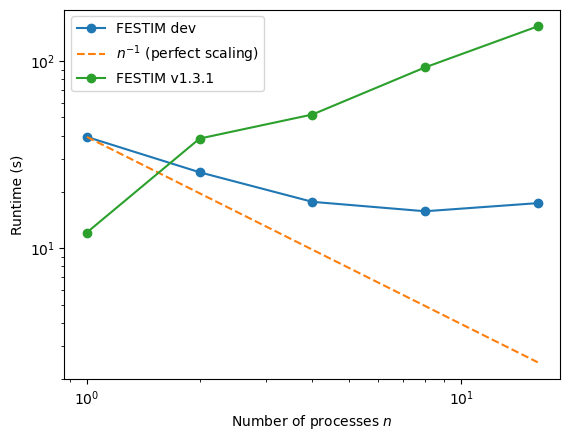

In [7]:
import matplotlib.pyplot as plt
from festim import __version__

plt.plot(num_procs, runtimes, marker="o", label=f"FESTIM dev")

n = np.linspace(1, 16, 100)
plt.plot(n, runtimes[0] * n**-1, linestyle="--", label="$n^{-1}$ (perfect scaling)")

plt.xlabel("Number of processes $n$")
plt.ylabel("Runtime (s)")

plt.xscale("log")
plt.yscale("log")

# check that runtimes_festim_1.csv exists and plot the results
try:
    import pandas as pd
    data = pd.read_csv("runtimes_festim_1.csv")
    plt.plot(data["num_procs"], data["runtimes"], marker="o", label="FESTIM v1.3.1")
except FileNotFoundError:
    print("File runtimes_festim_1.csv not found")

plt.legend()
plt.show()

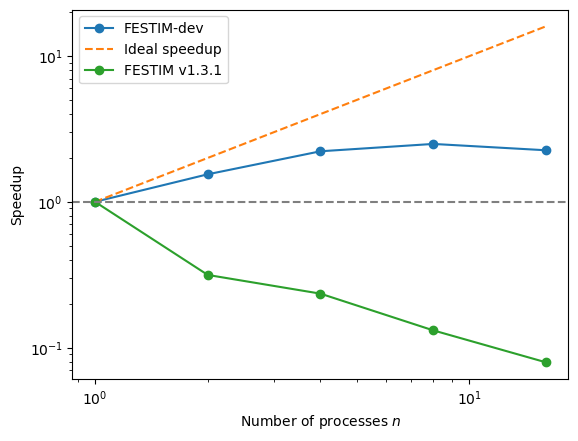

In [8]:
speedup = runtimes[0] / runtimes

plt.plot(num_procs, speedup, marker="o", label=f"FESTIM-dev")
# ideal speedup
plt.plot(n, n, linestyle="--", label="Ideal speedup")


try:
    import pandas as pd
    data = pd.read_csv("runtimes_festim_1.csv")
    speedup = data["runtimes"][0] / data["runtimes"]
    plt.plot(data["num_procs"], speedup, marker="o", label="FESTIM v1.3.1")
except FileNotFoundError:
    print("File runtimes_festim_1.csv not found")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of processes $n$")
plt.ylabel("Speedup")

# horizontal line at 1
plt.axhline(1, color="tab:grey", linestyle="--")

plt.legend()
plt.show()